<a href="https://colab.research.google.com/github/SnowTrash/pyHikethroug/blob/main/Practica_3_DatosReales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Librerias

In [ ]:
pip install pyDOE

  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18168 sha256=45a6ddf5671260c50d12d9293b261d7029c786a9ea37b1c83252ff8f2a4095a0
  Stored in directory: /root/.cache/pip/wheels/ce/b6/d7/c6b64746dba6433c593e471e0ac3acf4f36040456d1d160d17
Successfully built pyDOE


In [ ]:
pip install sobol_seq

In [ ]:
pip install scipy

In [ ]:
pip install pyDOE2

  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE2: filename=pyDOE2-1.3.0-py3-none-any.whl size=25521 sha256=85ea019994dff829480d78642864d45fe76578c20ad5819dadc3f3806a203e2a
  Stored in directory: /root/.cache/pip/wheels/46/1f/29/6fda5c72f950841e39147ae603780ee913a62f977b4ad47ee4
Successfully built pyDOE2


In [ ]:
pip install pyswarm

  Preparing metadata (setup.py) ... done
  Created wheel for pyswarm: filename=pyswarm-0.6-py3-none-any.whl size=4464 sha256=2a25f0304dc8464879951a31d74984cfe88bc8c050a04fe6bfa9c2c03347411c
  Stored in directory: /root/.cache/pip/wheels/71/67/40/62fa158f497f942277cbab8199b05cb61c571ab324e67ad0d6
Successfully built pyswarm


In [ ]:
pip install matplotlib

## Maincode

Running DE with LHS sampling...


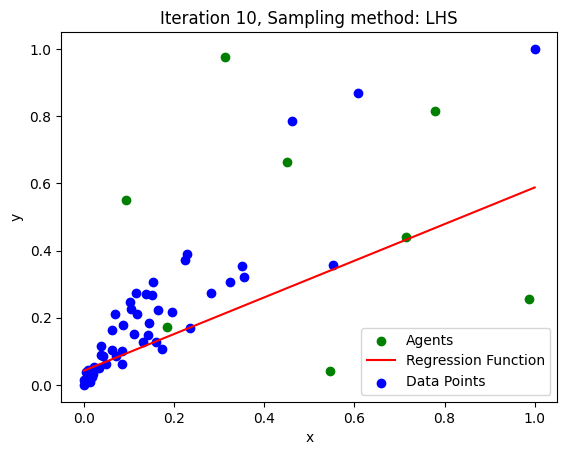

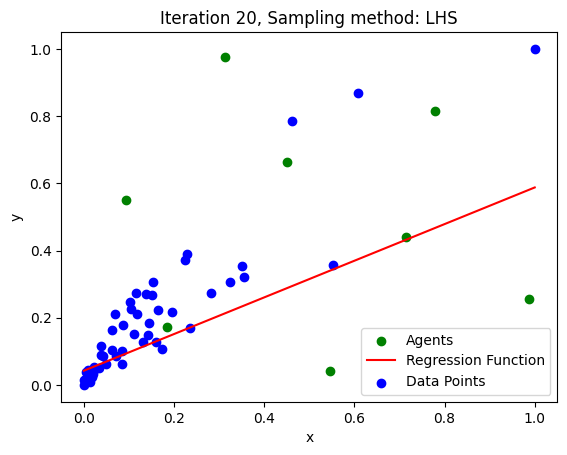

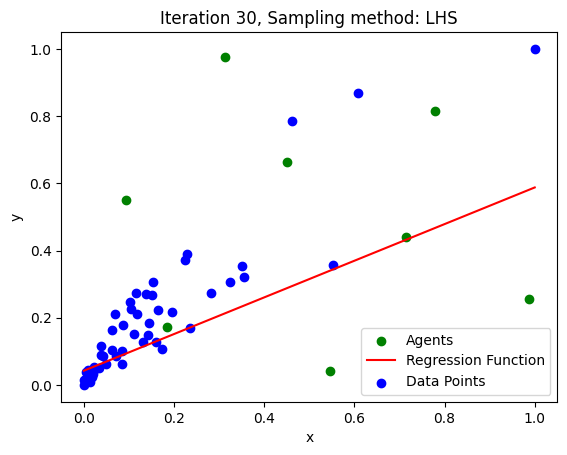

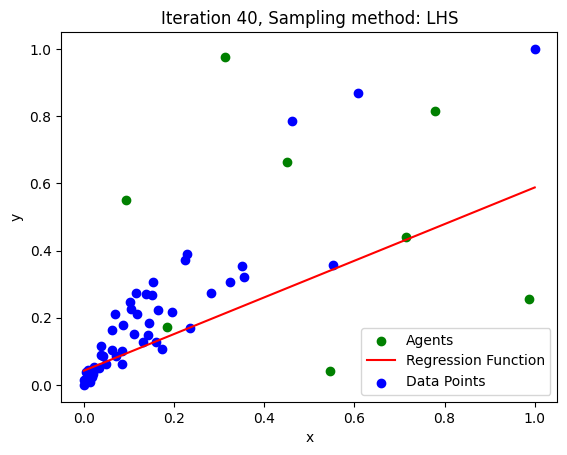

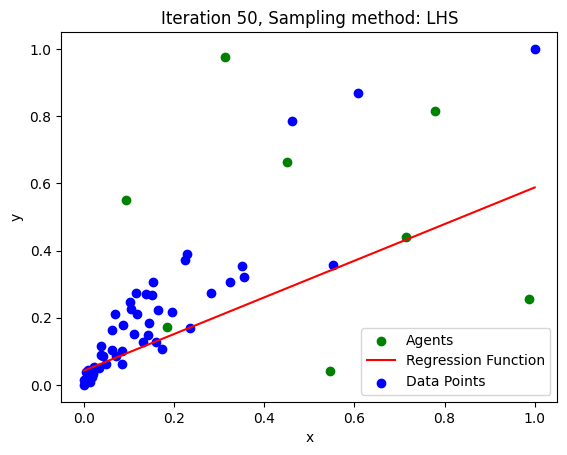

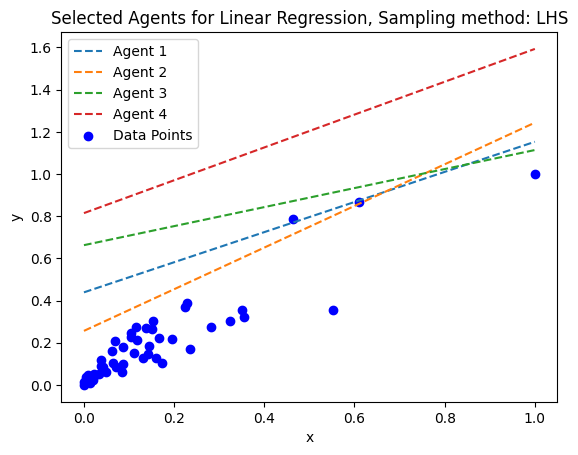

Running DE with Sobol sampling...


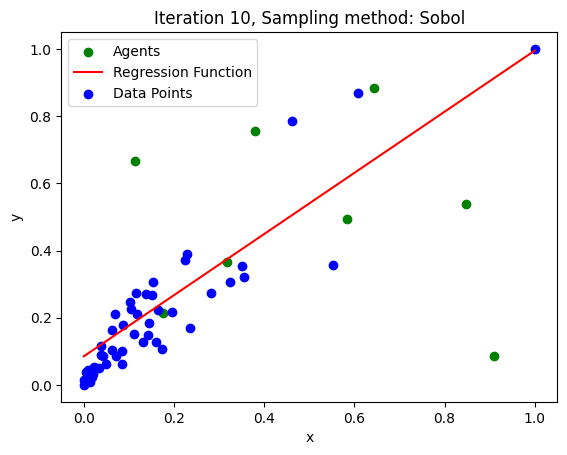

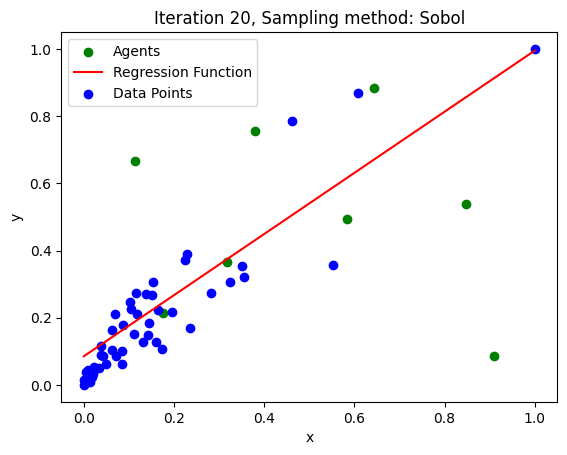

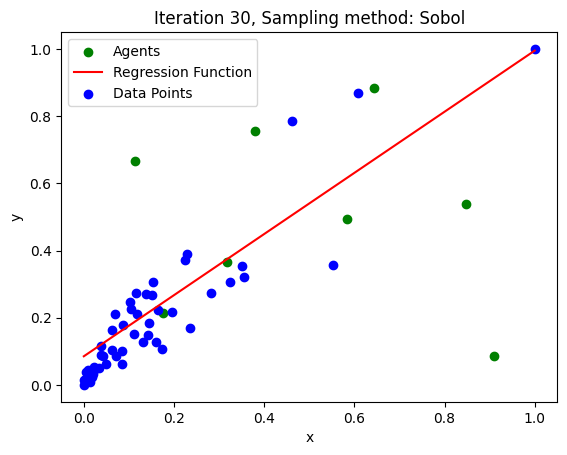

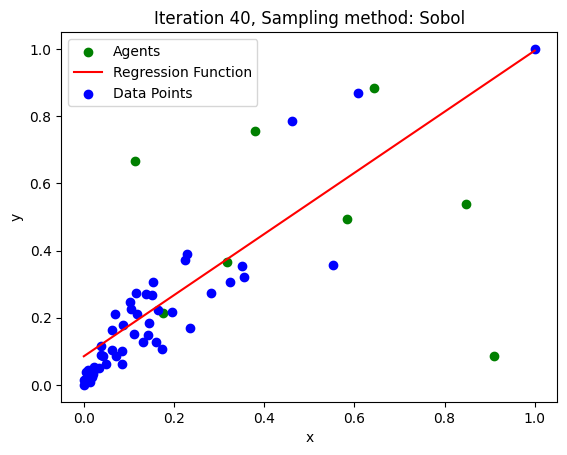

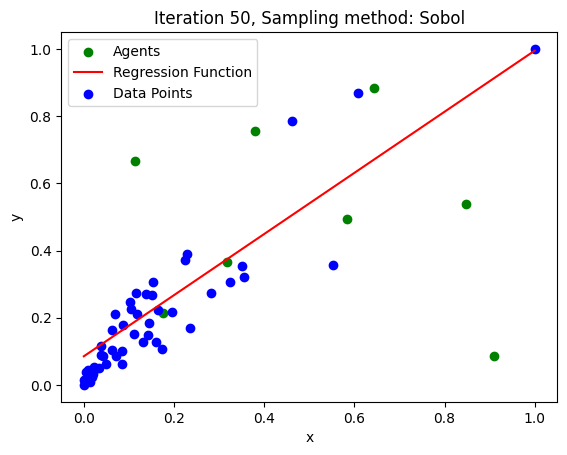

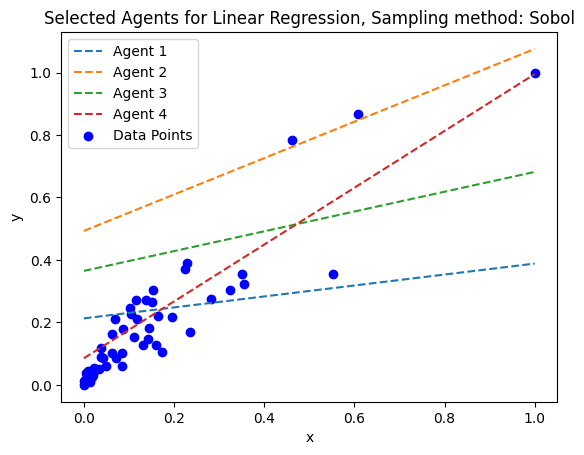

Running DE with Halton sampling...


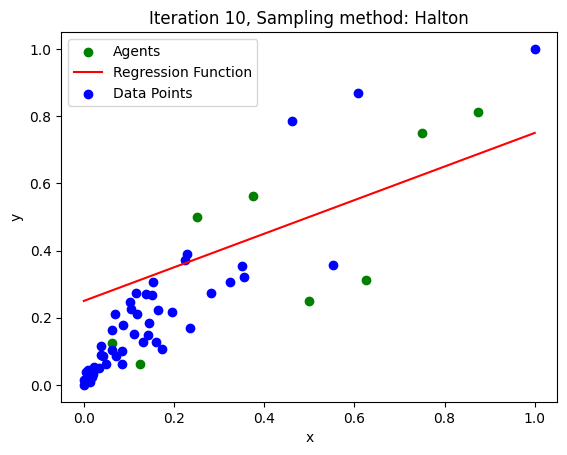

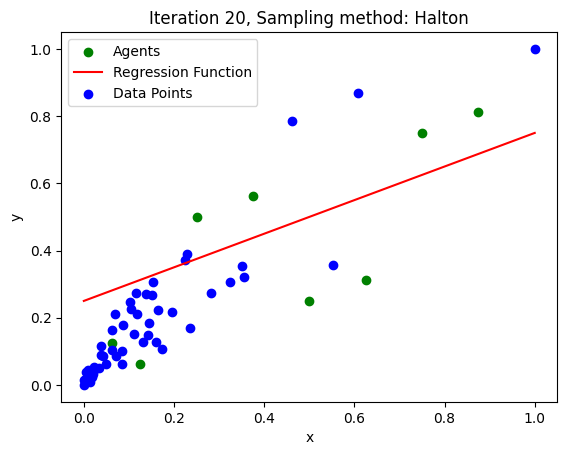

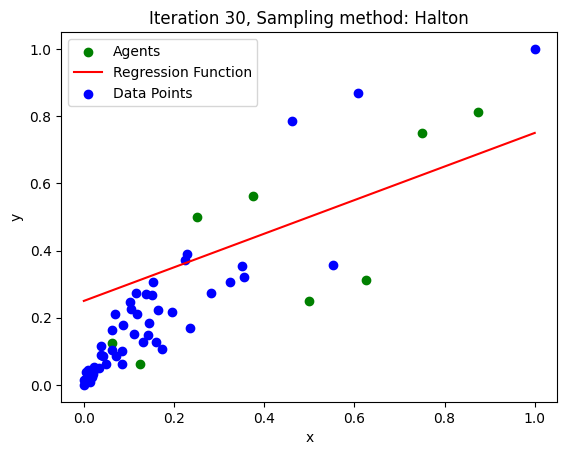

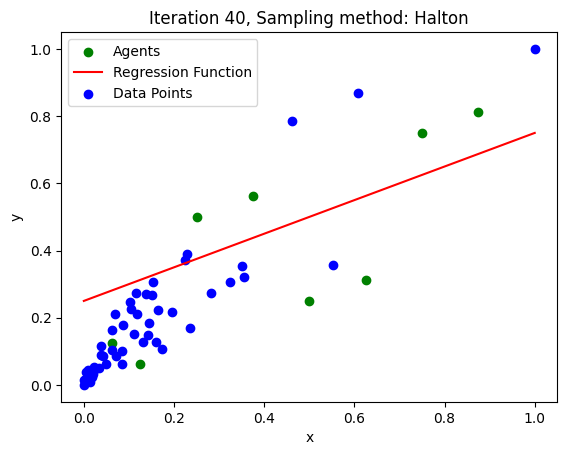

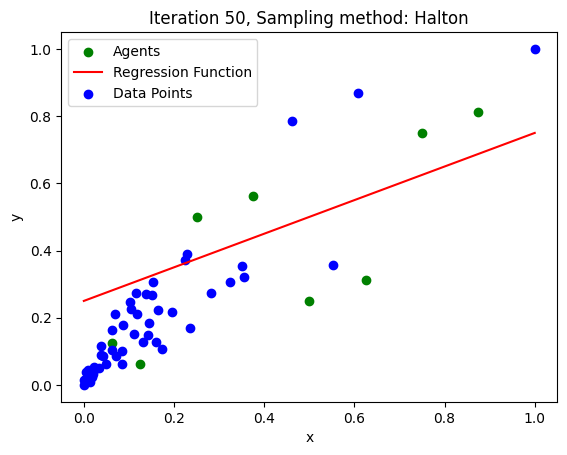

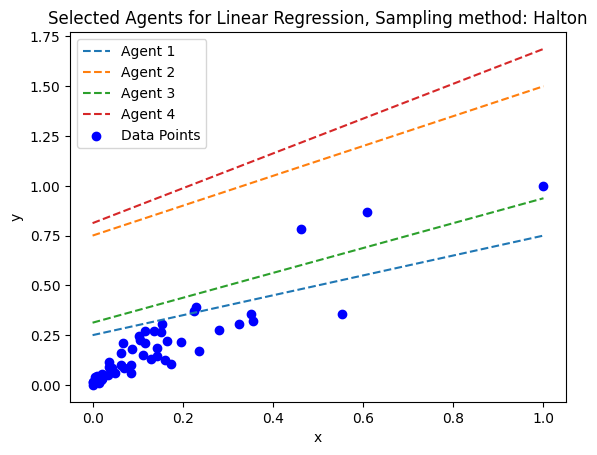

Running DE with UD sampling...


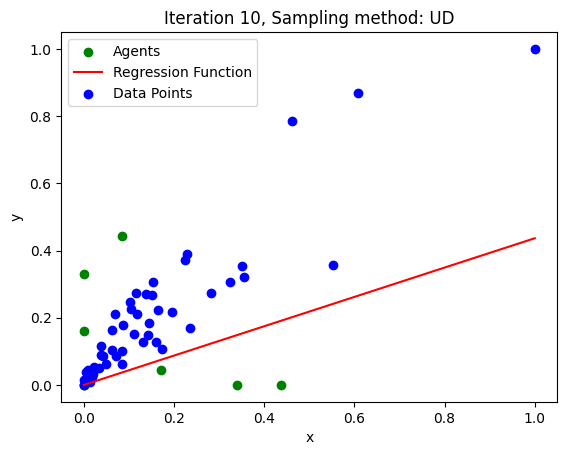

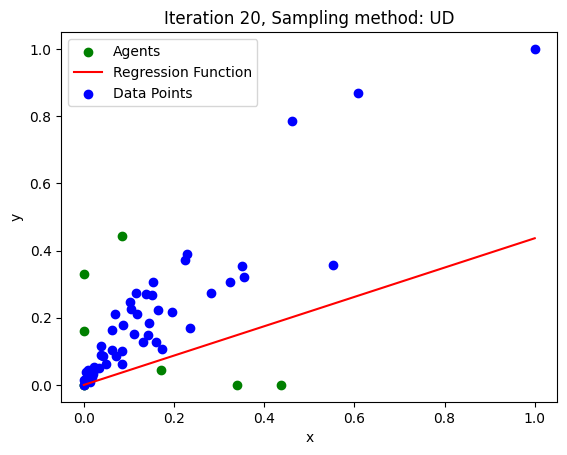

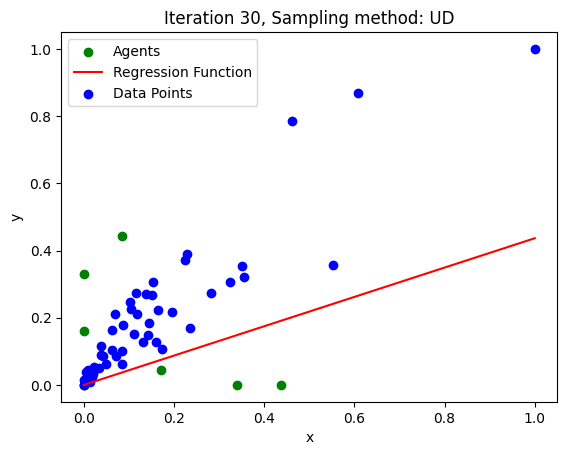

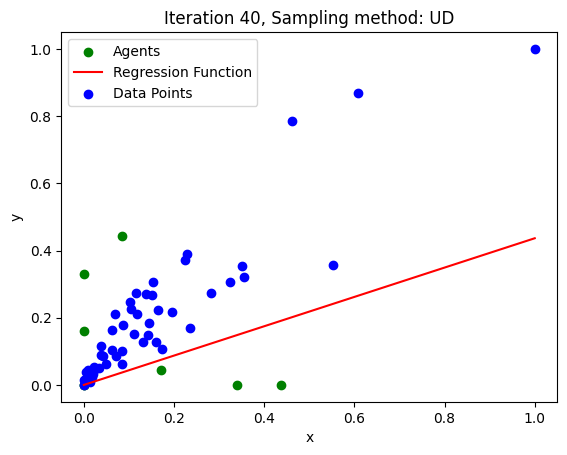

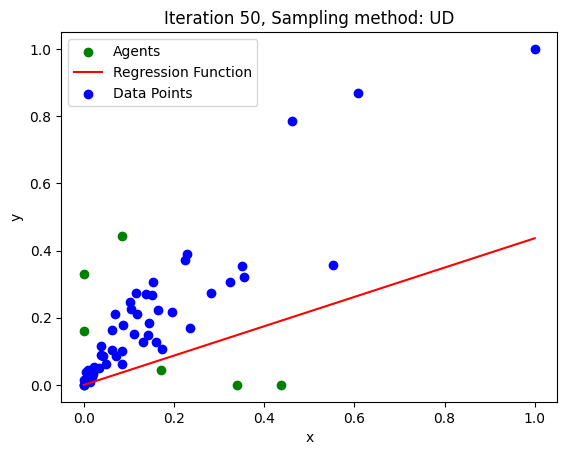

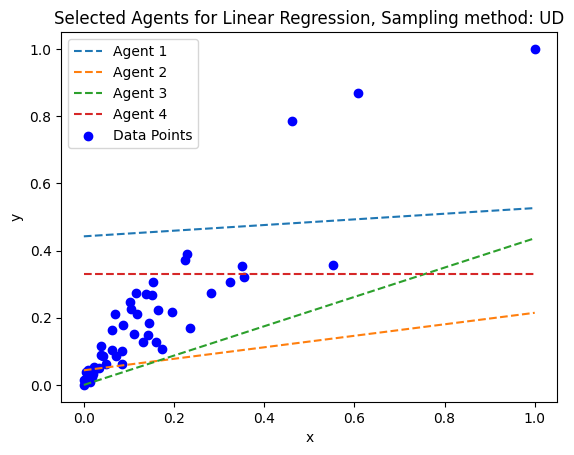

Running DE with Random sampling...


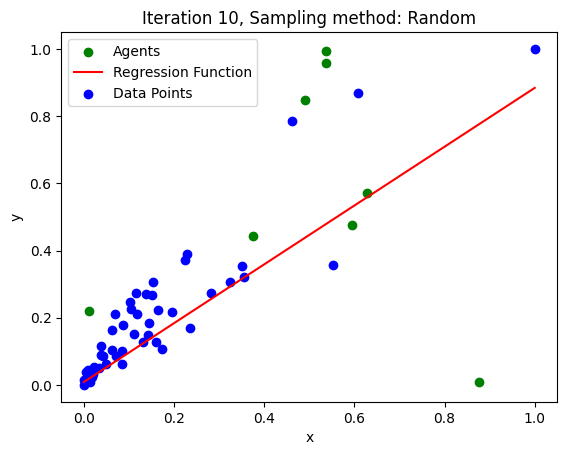

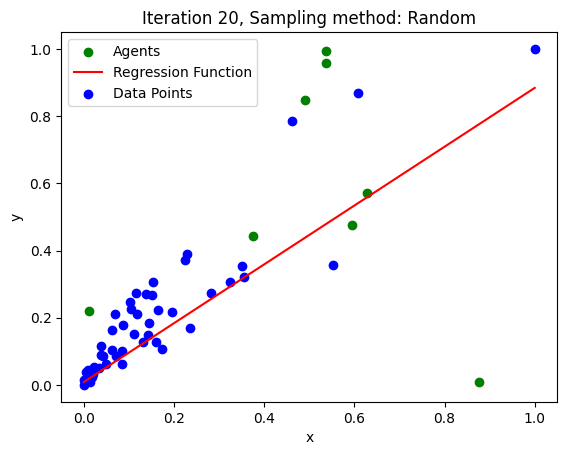

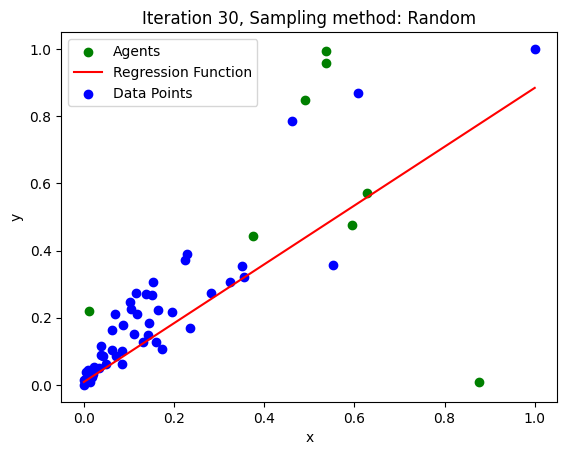

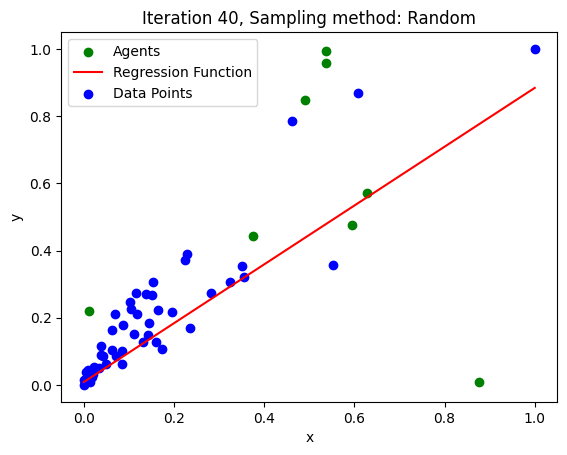

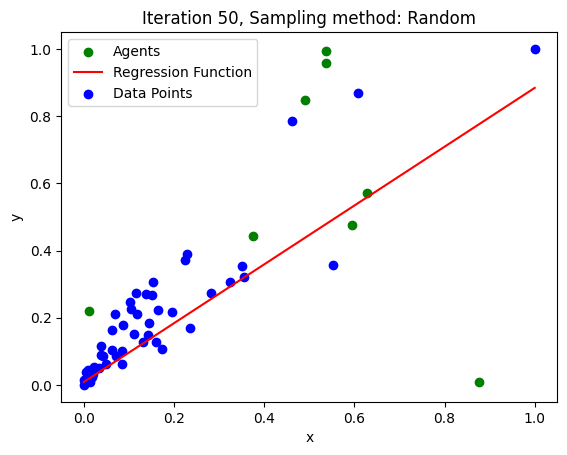

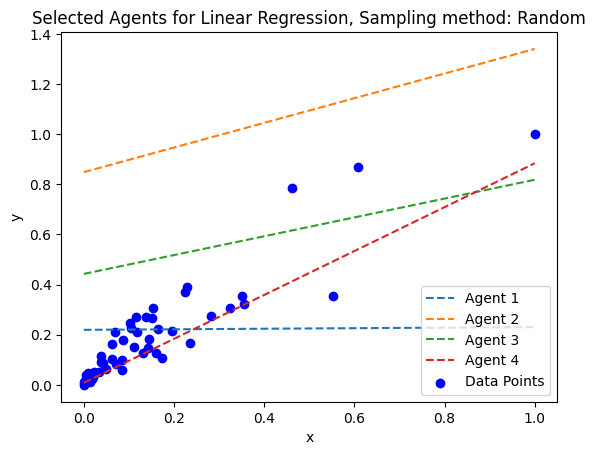

Running DE with CSFD sampling...


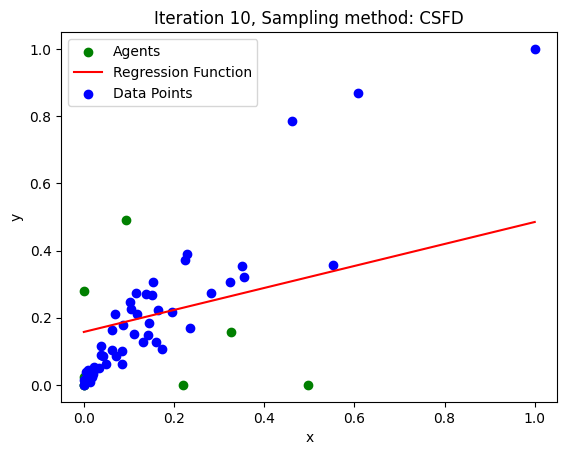

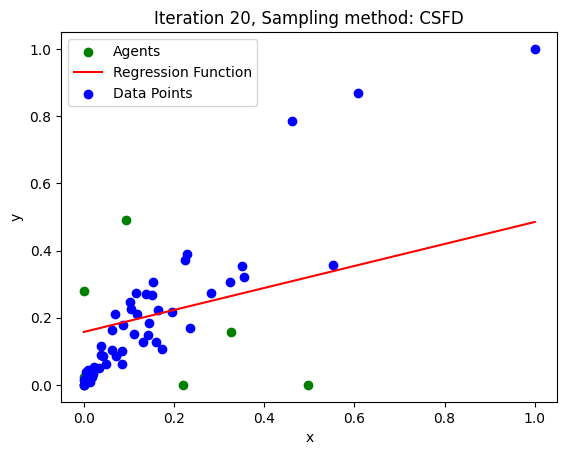

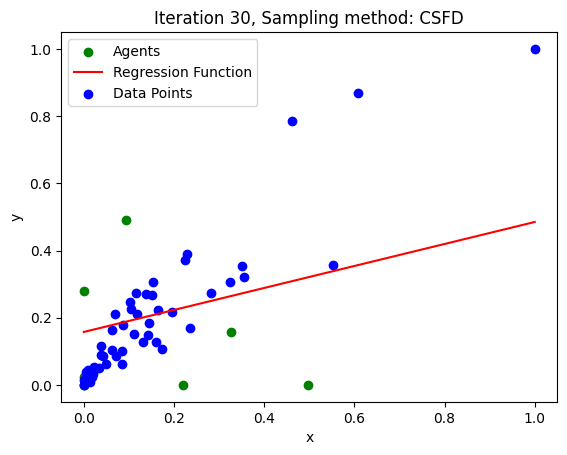

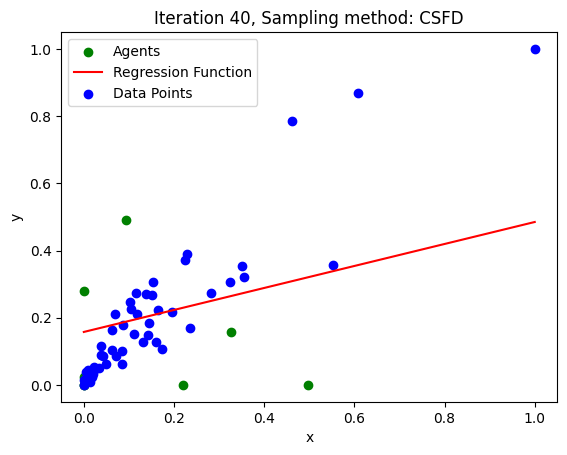

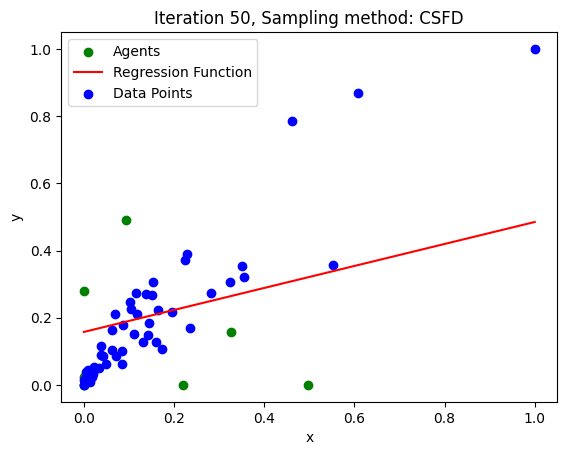

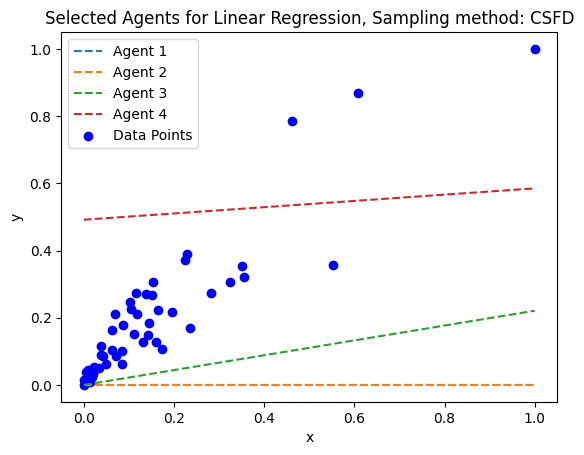


Best results for LHS:
Best parameters: [18732683.130929615, 215.57078741820794]
Best MSE: 0.020050


Best results for Sobol:
Best parameters: [30865566.34284769, 390.59395586140454]
Best MSE: 0.008055


Best results for Halton:
Best parameters: [17221853.5, 1062.25]
Best MSE: 0.032665


Best results for UD:
Best parameters: [15107542.596408667, 43.0]
Best MSE: 0.036011


Best results for Random:
Best parameters: [29721461.75034106, 78.30138635213811]
Best MSE: 0.010912


Best results for CSFD:
Best parameters: [11469598.486632796, 685.7887085822625]
Best MSE: 0.023520

Best sampling technique based on MSE:
Sampling method: Sobol
Best parameters: [30865566.34284769, 390.59395586140454]
Best MSE: 0.008055035009799434
Best sampling technique based on MSE:
Sampling method: Sobol
Best parameters: [30865566.34284769, 390.59395586140454]
Best MSE: 0.008055035009799434


In [32]:
import numpy as np
import matplotlib.pyplot as plt
from pyDOE2 import lhs
from scipy.stats import qmc
import pandas as pd  # Import pandas for reading data from CSV


# The maximum number of iterations is established.
dimensions = 2


# Read data from CSV
data = pd.read_csv("Datos.csv")
x = data["493782"].values  # Replace "x" with the actual column name in your CSV
y = data["164"].values  # Replace "y" with the actual column name in your CSV

# Normalize the data
x_min, x_max = np.min(x), np.max(x)
y_min, y_max = np.min(y), np.max(y)
x = (x - x_min) / (x_max - x_min)
y = (y - y_min) / (y_max - y_min)

# Adjust the search space based on the normalized data range
f_range = np.array([[0, 1], [0, 1]])

# The maximum number of iterations is established.
max_iter = 50

# Create regression data
#x, y = generate_regression_data(num_points=100, noise_stddev=0.1)

# Number of agents
num_agents = 8


# Function to initialize the population using different sampling techniques
def initialize_population(dimensions, f_range, num_agents, sampling_technique):
    if sampling_technique == "LHS":
        samples = lhs(dimensions, samples=num_agents, criterion="maximin", iterations=1000)
        agents = f_range[:, 0] + samples * (f_range[:, 1] - f_range[:, 0])
    elif sampling_technique == "Sobol":
        sobol_samples = qmc.Sobol(d=dimensions).random(num_agents)
        agents = f_range[:, 0] + sobol_samples * (f_range[:, 1] - f_range[:, 0])
    elif sampling_technique == "Halton":
        def halton_single(index, base):
            result = 0.0
            f = 1.0 / base
            i = index
            while i > 0:
                result += f * (i % base)
                i = int(i / base)
                f /= base
            return result

        agents = np.empty((num_agents, dimensions))
        for i in range(dimensions):
            sequence = np.zeros(num_agents)
            for j in range(num_agents):
                sequence[j] = halton_single(j + 1, 2 + i * 2)
            agents[:, i] = f_range[i, 0] + sequence * (f_range[i, 1] - f_range[i, 0])
    elif sampling_technique == "UD":
        ud_samples = lhs(dimensions, samples=num_agents, criterion="maximin", iterations=1000)
        centered_samples = ud_samples - 0.5
        agents = f_range[:, 0] + centered_samples * (f_range[:, 1] - f_range[:, 0])
    elif sampling_technique == "Random":
        agents = np.random.rand(num_agents, dimensions) * (f_range[:, 1] - f_range[:, 0]) + f_range[:, 0]
    elif sampling_technique == "CSFD":
        lhs_samples = lhs(dimensions, samples=num_agents, criterion="maximin", iterations=1000)
        centered_samples = lhs_samples - 0.5
        agents = f_range[:, 0] + centered_samples * (f_range[:, 1] - f_range[:, 0])
    else:
        raise ValueError("Invalid sampling technique")

    return agents


def differential_evolution(agents, max_iter, m, cross_p, plot_interval=10, technique=None):
    dimensions = agents.shape[1]
    num_agents = agents.shape[0]
    best_params = None
    best_mse = np.inf
    mse = np.empty(num_agents)
    fitness = np.empty(num_agents)

    x_reg = np.linspace(0, 1, 100)

    selected_agents = []  # Create a list to store selected agents in each iteration

    for i in range(num_agents):
        params = agents[i]
        y_pred = params[0] * x + params[1]
        mse[i] = np.mean((y - y_pred) ** 2)

        if mse[i] < best_mse:
            best_params = params
            best_mse = mse[i]

    iter = 1
    while iter <= max_iter:
        selected_agents_iteration = []  # List to store selected agents in this iteration
        for i in range(num_agents):
            # five different individuals are chosen.
            indexes = np.arange(num_agents)
            indexes = indexes[indexes != i]
            indexes = np.random.choice(indexes, 5, replace=False)
            agents_selected = agents[indexes]

            # The crossover operation is performed to obtain the mutant vector.
            mut = agents_selected[0] + m * (agents_selected[1] - agents_selected[2])

            # The differential mutation of the DE algorithm is performed.
            prob_vector = np.random.rand(dimensions) <= cross_p
            mut = agents[i] * prob_vector + mut * np.logical_not(prob_vector)

            # It is verified that the generated vector is within the search space defined by the upper and lower limits.
            for j in range(dimensions):
                upper_limit = f_range[j, 1]
                lower_limit = f_range[j, 0]

                if mut[j] < lower_limit:
                    mut[j] = lower_limit
                elif mut[j] > upper_limit:
                    mut[j] = upper_limit

            # Calculate the fitness of the mutant vector
            y_pred_mut = mut[0] * x + mut[1] # Calculate predicted values for the mutant
            mse_mut = np.mean((y - y_pred_mut) ** 2)  # Calculate MSE for the mutant

            # The replacement mechanism is then performed.
            if mse_mut < mse[i]:
                agents[i] = mut
                mse[i] = mse_mut
                if mse[i] < best_mse:
                    best_params = agents[i]
                    best_mse = mse[i]

            # Update the y_reg line with the current best_params
            y_reg = best_params[0] * x_reg + best_params[1]

            # Check if this agent was selected for linear regression
            if i%2 == 0:
                selected_agents_iteration.append(agents[i])

        selected_agents.append(selected_agents_iteration)

        # Add print statements for debugging
        #print(f"Iteration {iter} - Best MSE: {best_mse}, Best Params: {best_params}")

# Visualize the agents' positions and the regression function at specific iterations
        if iter % plot_interval == 0:

            plt.figure()
            plt.scatter(agents[:, 0], agents[:, 1], label="Agents", color='green')
            y_reg = best_params[0] * x_reg + best_params[1]  # Update y_reg for current best_params
            plt.plot(x_reg, y_reg, label="Regression Function", color='red')
            plt.scatter(x, y, label="Data Points", color='blue')
            plt.title(f"Iteration {iter}, Sampling method: {technique}")
            plt.xlabel("x")
            plt.ylabel("y")
            plt.legend()
            plt.show()


        iter += 1
        if iter > 299:
            print("Iteration:", iter)

    return best_params, best_mse ,selected_agents


# List of sampling techniques to compare
sampling_techniques = ["LHS", "Sobol", "Halton", "UD", "Random", "CSFD"]

# Dictionary to store the results
results = {}

# Dictionary to store fitness values for each technique
fitness_values = {}

# Run DE for each sampling technique and store the results and selected agents
for technique in sampling_techniques:
    print(f"Running DE with {technique} sampling...")
    agents = initialize_population(dimensions, f_range, num_agents, technique)

    # default m and cross_p (0.5 , 0.2)
    best_params, best_mse, selected_agents = differential_evolution(agents, max_iter, 2.5, 1.4, technique=technique)

        # Denormalize the best parameters
    best_params_denormalized = [
        best_params[0] * (x_max - x_min) + x_min,
        best_params[1] * (y_max - y_min) + y_min
    ]

    results[technique] = (best_params_denormalized, best_mse)

    # Store the fitness value
    fitness_values[technique] = best_mse

    # Retrieve the selected agents for the last iteration
    selected_agents_last_iteration = selected_agents[-1]

    # Create a plot for the selected agents
    plt.figure()
    for i, agent in enumerate(selected_agents_last_iteration):
        y_reg_selected = agent[0] * x + agent[1]
        plt.plot(x, y_reg_selected, label=f"Agent {i + 1}", linestyle='--')

    # Update the y_reg line with the best_params for this technique
    y_reg = best_params[0] * x + best_params[1]

    plt.scatter(x, y, label="Data Points", color='blue')
    plt.title(f"Selected Agents for Linear Regression, Sampling method: {technique}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.show()

# Print the best results for each sampling method
for method, result in results.items():
    print(f"\nBest results for {method}:")
    print(f"Best parameters: {result[0]}")
    print(f"Best MSE: {result[1]:.6f}\n")  # Format MSE with 6 decimal places

# Determine the "best technique" based on the lowest MSE value
best_technique = min(fitness_values, key=lambda k: fitness_values[k])
best_params = results[best_technique][0]
best_mse = results[best_technique][1]

# Print the best results
print("Best sampling technique based on MSE:")
print(f"Sampling method: {best_technique}")
print(f"Best parameters: {best_params}")
print(f"Best MSE: {best_mse}")

# Determine the "best technique" based on the lowest MSE value
best_technique = min(fitness_values, key=lambda k: fitness_values[k])
best_params = results[best_technique][0]
best_mse = results[best_technique][1]

# Print the best results
print("Best sampling technique based on MSE:")
print(f"Sampling method: {best_technique}")
print(f"Best parameters: {best_params}")
print(f"Best MSE: {best_mse}")